# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [82]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create a body

In [2]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


In [89]:
Npts = 100
len = 1.0
thick = 0.023
λ = thick/len
xcent = [0.0,0.0]
ang = -π/4
b = Bodies.Plate(Npts,len,thick,λ,xcent,ang)

Body: number of points = 364, reference point = (0.0,0.0), rotation matrix = [0.707107 0.707107; -0.707107 0.707107]


### Create a domain with this body in it

In [90]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 364, reference point = (0.0,0.0), rotation matrix = [0.707107 0.707107; -0.707107 0.707107]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [91]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 364, reference point = (0.0,0.0), rotation matrix = [0.707107 0.707107; -0.707107 0.707107]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [92]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [93]:
@time gops, ops = NavierStokes.set_operators_body!(dom,params);

 14.349268 seconds (960.73 k allocations: 3.340 GiB, 4.59% gc time)


### Create an initial solution structure

In [94]:
s = NavierStokes.BodySoln(dom)
h = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Float64,2},Array{Float64,2}},1}:
 Solution: t = 0.0


### Advance the solution

In [95]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

  9.548644 seconds (5.84 M allocations: 2.278 GiB, 4.88% gc time)


Solution: t = 1.0000000000000007


In [96]:
@time f = NavierStokes.evaluateFields.(h,dom.grid,gops);

  2.529674 seconds (122.20 k allocations: 225.271 MiB, 5.88% gc time)


In [10]:
t = [copy(f[i].t) for i = 1:length(f)];
@time ux = [copy(f[i].ux) for i = 1:length(f)];

  0.065259 seconds (27.75 k allocations: 16.781 MiB, 5.84% gc time)


In [11]:
spts = Process.SamplePoint(1.5,1.5)

Whirl2d.Process.SamplePoints([1.5], [1.5])

In [12]:
x = Grids.xfacex(dom.grid)
y = Grids.yfacex(dom.grid)
uxsamp = Process.sample(spts,ux,x,y)

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0144011, 0.0147398, 0.0150096, 0.0152371, 0.0154388, 0.0156248, 0.0158013, 0.0159724, 0.0161409  …  0.0426251, 0.0431246, 0.0436275, 0.0441339, 0.0446436, 0.0451566, 0.0456728, 0.0461922, 0.0467147, 0.0472403]

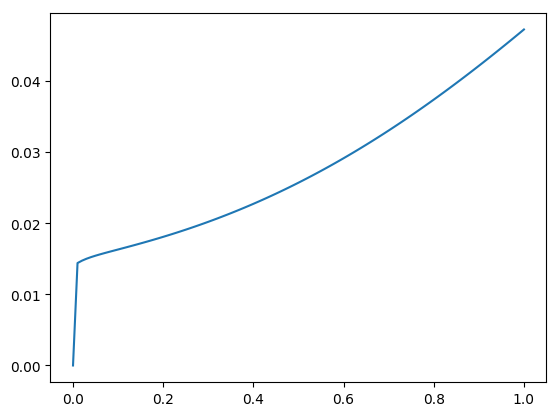

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x137d030d0>

In [13]:
plot(t,uxsamp[1])

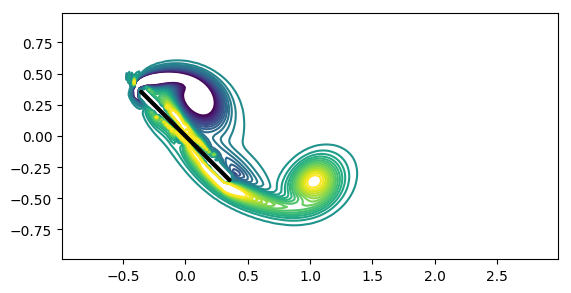

(-0.99, 2.99, -0.99, 0.99)

In [97]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(f[end].ω),linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

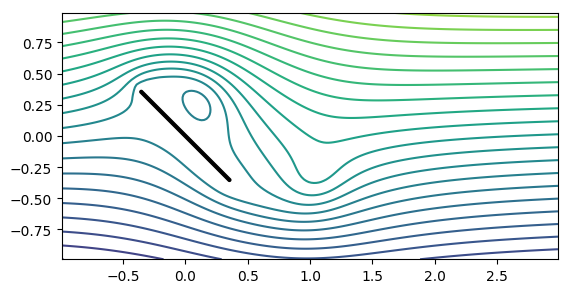

(-0.99, 2.99, -0.99, 0.99)

In [98]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
contour(x,y,y.+transpose(f[end].ψ),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

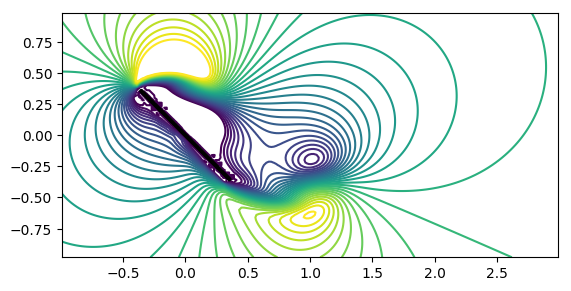

(-0.99, 2.99, -0.98, 0.98)

In [99]:
contour(Grids.xfacex(dom.grid),Grids.yfacex(dom.grid),transpose(f[end].ux).+1,linspace(0,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

In [24]:
len = 1
thick = 0.023
N = 10
x = [[[len*(-0.5 + 1.0*(i-1)/(N-1)),0.0] for i=1:N];
     [[0.0,0.0] for i = 1:N]]

20-element Array{Array{Float64,1},1}:
 [-0.5, 0.0]      
 [-0.388889, 0.0] 
 [-0.277778, 0.0] 
 [-0.166667, 0.0] 
 [-0.0555556, 0.0]
 [0.0555556, 0.0] 
 [0.166667, 0.0]  
 [0.277778, 0.0]  
 [0.388889, 0.0]  
 [0.5, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       
 [0.0, 0.0]       

In [55]:
N = 100
t = 0.023
λ = t
Δϕ = π/N
Jϕa = [sqrt(sin(ϕ)^2+λ^2*cos(ϕ)^2) for ϕ in linspace(π-Δϕ/2,Δϕ/2,N)]
Jϕ = len*Jϕa/Δϕ/sum(Jϕa)
xtopface = -0.5*len + Δϕ*cumsum([0.0; Jϕ])
xtop = 0.5*(xtopface[1:N] + xtopface[2:N+1])
x = [[xi,0.5*t] for xi in xtop[end:-1:1]];

In [58]:
Δsₑ = Δϕ*Jϕ[1]
Nₑ = 2*floor(Int,0.25*π*t/Δsₑ)

82

In [57]:
?floor

search: floor OverflowError FileMonitor StackOverflowError default_worker_pool



```
floor([T,] x, [digits, [base]])
```

`floor(x)` returns the nearest integral value of the same type as `x` that is less than or equal to `x`.

`floor(T, x)` converts the result to type `T`, throwing an `InexactError` if the value is not representable.

`digits` and `base` work as for [`round`](@ref).

```
floor(dt::TimeType, p::Period) -> TimeType
```

Returns the nearest `Date` or `DateTime` less than or equal to `dt` at resolution `p`.

For convenience, `p` may be a type instead of a value: `floor(dt, Dates.Hour)` is a shortcut for `floor(dt, Dates.Hour(1))`.

```jldoctest
julia> floor(Date(1985, 8, 16), Dates.Month)
1985-08-01

julia> floor(DateTime(2013, 2, 13, 0, 31, 20), Dates.Minute(15))
2013-02-13T00:30:00

julia> floor(DateTime(2016, 8, 6, 12, 0, 0), Dates.Day)
2016-08-06T00:00:00
```
